In [77]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Load and display MNIST handwritten digits dataset

In [79]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [80]:
# see how many images are there for each digit
for j in np.arange(10):
    idx = np.where(y==str(j))
    idx = np.asarray(idx)[0,:]
    print('digit %i length %i' % (j, len(idx)))

digit 0 length 6903
digit 1 length 7877
digit 2 length 6990
digit 3 length 7141
digit 4 length 6824
digit 5 length 6313
digit 6 length 6876
digit 7 length 7293
digit 8 length 6825
digit 9 length 6958


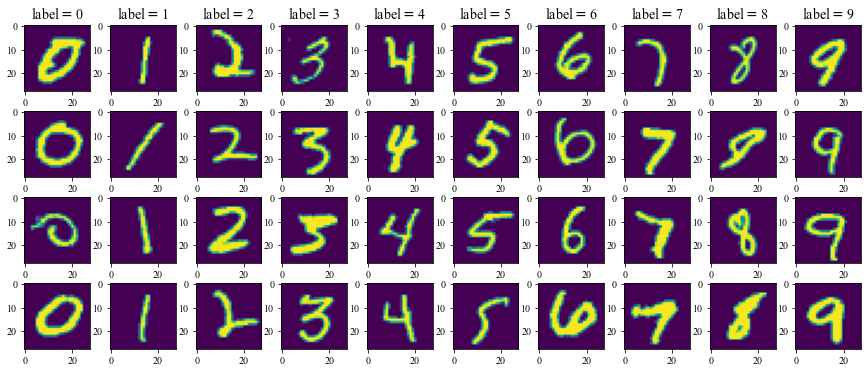

In [179]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        ax[i,j].imshow(X[idx_subsampled[i],:].reshape(28,28))
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]]) 
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]]) 
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_ex1.pdf', bbox_inches='tight')

In [85]:
# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []
for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (55813, 784)
X_test.shape (14187, 784)
y_train.shape (55813, 1)
y_test.shape (14187, 1)


In [181]:
def sample_binary_MNIST(list_digits=['0','1'], full_MNIST=None):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        if y01[i] == str(list_digits[1]):
            label = 1

        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(label)
        else:
            X_test.append(X01[i,:])
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).reshape(-1,1)
    y_test = np.asarray(y_test).reshape(-1,1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test, sample_binary_MNIST(list_digits=['0','1'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (11102, 784)
X_test.shape (2713, 784)
y_train.shape (11102, 1)
y_test.shape (2713, 1)


## Logistic Regression

In [147]:
# sigmoid and logit function 
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

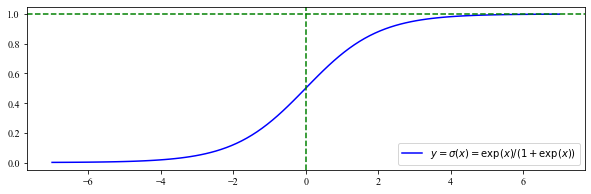

In [148]:
# plot sigmoid function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,3])
x = np.linspace(-7, 7, 100)
ax.plot(x, sigmoid(x), color='blue', label="$y=\sigma(x)=\exp(x)/(1+\exp(x))$")
plt.axhline(y=1, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
ax.legend()
plt.savefig('sigmoid_ex.pdf', bbox_inches='tight')

In [149]:
def fit_LR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Logistic Regression using Gradient Descent 
        Y = (n x 1), H = (p x n) (\Phi in lecture note), W = (p x 1)
        Logistic Regression: Y ~ Bernoulli(Q), Q = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) ) 
        '''
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        dist = 1
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

<ipython-input-149-5dc4e4fed598>:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


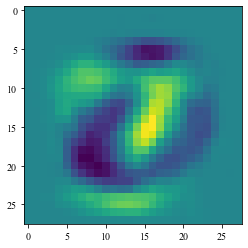

In [150]:
# fit logistic regression using GD

X_train, X_test, y_train, y_test = sample_binary_MNIST(['0', '7'], full_MNIST = [X,y])
# Feature matrix of size (p x n) = (feature dim x samples)
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
W = fit_LR_GD(Y=y_train, H=H_train) 

plt.imshow(W[1:,:].reshape(28,28))

<ipython-input-149-5dc4e4fed598>:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


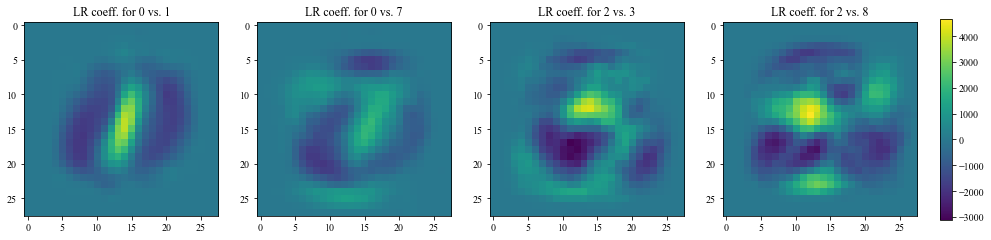

In [178]:
# plot fitted polynomial regression curve
digit_list_list = [['0','1'],['0','7'],['2','3'],['2', '8']] # list of list of two digits
# fit LR for each cases
W_array = []
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=L, full_MNIST = [X,y])
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
    W = fit_LR_GD(Y=y_train, H=H_train) 
    W = fit_LR_GD(Y=y_train, H=H_train) 
    W_array.append(W.copy())

W_array = np.asarray(W_array)


# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(digit_list_list), figsize=[16, 4])
for i in np.arange(len(digit_list_list)):
    L = digit_list_list[i]
    W = W_array[i]
    im = ax[i].imshow(W[1:,:].reshape(28,28), vmin=np.min(W_array), vmax=np.max(W_array))
    ax[i].title.set_text("LR coeff. for %s vs. %s" % (L[0], L[1])) 
    # ax[i].legend()
    images.append(ax[i])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('LR_MNIST_training_ex.pdf', bbox_inches='tight')

In [ ]:
# plot the test error for multiple values of hyperparameters 

deg_list = np.arange(1,10)
alpha_list = [0, 0.001, 0.01, 0.1, 1]
error_train_mx = np.zeros(shape=[len(deg_list), len(alpha_list)])
error_test_mx = np.zeros(shape=[len(deg_list), len(alpha_list)])

for i in np.arange(len(deg_list)):
    for j in np.arange(len(alpha_list)):
        y_hat_train, w_hat = poly_regression(x_train, y_train, deg=deg_list[i], alpha=alpha_list[j])
        y_hat_test = make_poly_matrix(x_test, deg=deg_list[i]) @ w_hat
        error_train_mx[i, j] = np.linalg.norm(y_train-y_hat_train, 2)**2/N
        error_test_mx[i, j] = np.linalg.norm(y_test-y_hat_test, 2)**2/N
# print('!!!', error_mx)


# make plot
ncols = 3
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,4])
for i in np.arange(ncols):
    ax[i].plot(deg_list, error_train_mx[:,i], color='blue', label="train error")
    ax[i].plot(deg_list, error_test_mx[:,i], color='red', label="test error")
    ax[i].set_xlabel('degree', fontsize=10)
    ax[i].title.set_text("num training ex = %i, \n L2 regularizer = %.3f" % (N, alpha_list[i])) 
    ax[i].set_ylabel('MSE', fontsize=10)
    ax[i].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('poly_error_ex_2.pdf')


## Polynomial Regression + Gaussian Noise

In [ ]:
def eval_polynomial(p,x):
    # p = list of coefficients; p[0] = constant term
    return sum((a*x**i for i,a in enumerate(p)))

In [ ]:
def uniform(a,b):
    # sample a uniform random variable from the interval [a,b]
    return a + (b-a)*np.random.rand()

In [ ]:
def poly_regression_ML(x_train, y_train, deg=9):
    # compute MLE for the coefficients w and noise variance 
    # for the poylnimal regression model with given degree
    y_hat_train, w_hat = poly_regression(x_train, y_train, deg=deg, alpha=0)
    var_hat = (1/len(x_train))*np.linalg.norm(y_train - y_hat_train,2)**2 
    return w_hat, var_hat

In [ ]:
# Plot polynomial + Gaussian noise data

np.random.seed(1)
N = 100
p = [-6,11.5,-6,1] # coefficients of the polynomial; p[0]=constarnt term

# make plot
sigma_list = [0, 0.1, 1]
fig, ax = plt.subplots(nrows=1, ncols=len(sigma_list), figsize=[13,4])
x = np.linspace(1, 3, 100)
y = eval_polynomial(p, x)

for i in np.arange(len(sigma_list)):
    sigma = sigma_list[i]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for k in np.arange(N):
        U1 = uniform(1,3)
        e1 = np.random.normal(0,sigma**2)
        x_train.append(U1)
        y_train.append(eval_polynomial(p,U1)+e1)

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    
    markers, caps, bars = ax[i].errorbar(x, y, yerr=sigma, fmt='', marker=None, label="$y=$mean", errorevery=100)
    ax[i].fill_between(x, y - sigma, y + sigma, facecolor='g', alpha=0.2)
    ax[i].plot(x_train, y_train, '.', color='blue', label="$y+\epsilon$")
    ax[i].title.set_text("std of noise = %.2f" % sigma) 
    ax[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('poly_noise_ex.pdf')
    

In [ ]:
# fit poly regression + ML and plot 

np.random.seed(1)
N = 100
p = [-6,11.5,-6,1] # coefficients of the polynomial; p[0]=constarnt term
# p = [3, 0, 0, 0]
deg = 9
sigma_list = [0.3, 1]


fig, ax = plt.subplots(nrows=1, ncols=len(sigma_list), figsize=[12,5])
x = np.linspace(1, 3, 100)
y = eval_polynomial(p, x)

for i in np.arange(len(sigma_list)):
    sigma = sigma_list[i]
    
    # generate data 
    x_train = []
    y_train = []
    for k in np.arange(N):
        U1 = U1 = uniform(1,3)
        e1 = np.random.normal(0,sigma**2)
        x_train.append(U1)
        y_train.append(eval_polynomial(p,U1)+e1)

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    
    w_hat, var_hat = poly_regression_ML(x_train, y_train, deg=deg)
    std_hat = np.sqrt(var_hat)
    y_hat_mean = make_poly_matrix(x, deg=M) @ w_hat

    markers, caps, bars = ax[i].errorbar(x, y_hat_mean, yerr=std_hat, fmt='', color='y', marker=None, label="$y=$predicted mean", errorevery=100)
    ax[i].fill_between(x, y_hat_mean - std_hat, y_hat_mean + std_hat, facecolor='y', alpha=0.2)
    ax[i].plot(x_train, y_train, '.', color='blue', label="train data")
    ax[i].plot(x, y, color='red', label="$y=$true poly")
    ax[i].title.set_text("std of noise = %.2f" % sigma) 
    ax[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('poly_noise_ML_ex.pdf', bbox_inches='tight')

## Bayesian Polynomial Regression

In [ ]:
def bayesian_poly_regression(x_train, y_train, x, deg=9, tau=0.1, sigma=0.1):
    # fit Bayesian polynomial regression of given degree with Gaussian prior on coefficients w:
    # w ~ N(0, \tau^2 I)
    # sigma = known noise std
    # Output is the mean and variance of the predictive Gaussian distribution for input x
    x_vec = make_poly_matrix([x], deg=deg).T
    X = make_poly_matrix(x_train, deg=deg)
    S1 = tau**(-2) * np.identity(deg+1) + sigma**(-2) * X.T @ X
    S = np.linalg.pinv(S1)
    mean_w = sigma**(-2) * S @ X.T @ y_train
    mean = mean_w.T @ x_vec
    # print('!!! mean.shape', mean.shape)
    var = sigma**(2) + x_vec.T @ S @ x_vec
    return mean[0], var[0,0]

bayesian_poly_regression(x_train, y_train, 1, deg=9, tau=0.1, sigma=0.1)

In [ ]:
# make plot
np.random.seed(1)
N = 100
p = [-6,11.5,-6,1] # coefficients of the polynomial; p[0]=constarnt term
# p=[3, 0, 0, 0]
deg = 9
tau = 10 # prior std of coefficients w
sigma_list = [0.3, 1]

fig, ax = plt.subplots(nrows=1, ncols=len(sigma_list), figsize=[12,5])
x = np.linspace(1, 3, 100)
y = eval_polynomial(p, x)

for i in np.arange(len(sigma_list)):
    sigma = sigma_list[i]
    
    # generate data 
    x_train = []
    y_train = []
    for k in np.arange(N):
        U1 = U1 = uniform(1,3)
        e1 = np.random.normal(0,sigma**2)
        x_train.append(U1)
        y_train.append(eval_polynomial(p,U1)+e1)

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    # compute prediction
    y_hat_mean = []
    y_hat_std = []
    for j in np.arange(len(x)):
        mean, var = bayesian_poly_regression(x_train, y_train, x=x[j], deg=deg, tau=tau, sigma=sigma)
        y_hat_mean.append(mean)
        y_hat_std.append(np.sqrt(var))

    y_hat_mean = np.asarray(y_hat_mean)
    y_hat_std = np.asarray(y_hat_std)
    
    markers, caps, bars = ax[i].errorbar(x, y_hat_mean, yerr=y_hat_std, fmt='', color='y', marker=None, label="$y=$predicted mean", errorevery=100)
    ax[i].fill_between(x, y_hat_mean - y_hat_std, y_hat_mean + y_hat_std, facecolor='y', alpha=0.2)
    ax[i].plot(x_train, y_train, '.', color='blue', label="train data")
    ax[i].plot(x, y, color='red', label="$y=$true poly")
    ax[i].title.set_text("std of noise = %.2f" % sigma) 
    ax[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('poly_noise_bayesian_ex.pdf', bbox_inches='tight')